In [1]:
!nvidia-smi

Sat Mar 15 07:25:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P4             11W /   35W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Dataset Shapes:
  Training set shape: (533333, 29)
  Validation set shape: (133334, 29)
  Test set shape: (333333, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([64, 28])
net.0.bias: torch.Size([64])
net.2.weight: torch.Size([64, 64])
net.2.bias: torch.Size([64])
net.4.weight: torch.Size([2, 64])
net.4.bias: torch.Size([2])


Epoch 1/25: Training Loss: 0.4035 | Training Accuracy: 81.24% | Validation Loss: 0.3616 | Validation Accuracy: 83.08% | LR: 0.001000 | Epoch Time: 25.79 sec
Epoch 2/25: Training Loss: 0.3518 | Training Accuracy: 83.33% | Validation Loss: 0.3349 | Validation Accuracy: 83.68% | LR: 0.001000 | Epoch Time: 25.20 sec
Epoch 3/25: Traini

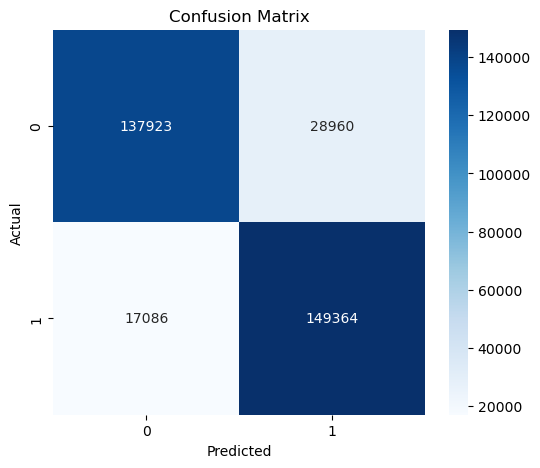

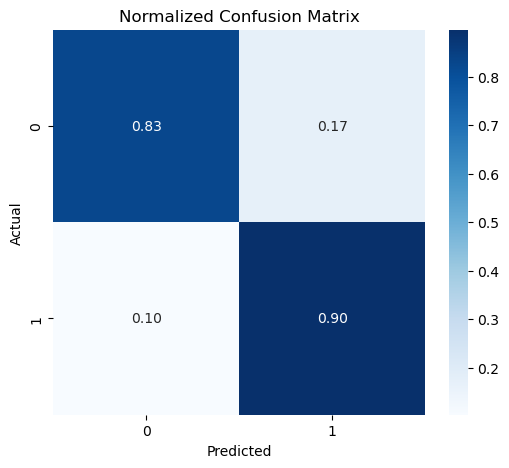

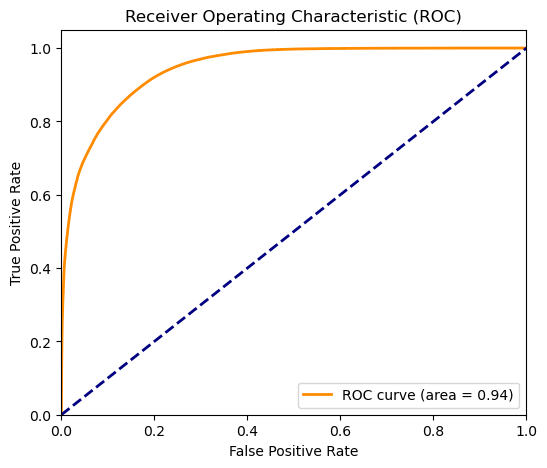

ROC AUC Score: 0.9450
CPU times: user 10min 24s, sys: 1min 35s, total: 11min 59s
Wall time: 11min 8s


In [3]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("all_train.csv").sample(n=666667, random_state=42)
test_df = cudf.read_csv("all_test.csv").sample(n=333333, random_state=42)

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("# label")
target_column = "# label"

# Split train_pd into training and validation sets (e.g., 80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 64      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # can improve performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Epoch-level Logging
# ---------------------------
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    epoch_start_time = time.time()
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    epoch_time = time.time() - epoch_start_time
    
    # Get current learning rate (assuming one parameter group)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary in a single line
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.2f}% | "
          f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}% | LR: {current_lr:.6f} | "
          f"Epoch Time: {epoch_time:.2f} sec")

# ---------------------------
# 7. Evaluate on Test Set and Compute Metrics
# ---------------------------
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        # Calculate probabilities using softmax; take probability of class "1"
        probs = nn.functional.softmax(outputs, dim=1)
        all_test_probs.extend(probs[:, 1].cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
# Compute ROC AUC Score
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


Dataset Shapes:
  Training set shape: (5600000, 29)
  Validation set shape: (1400000, 29)
  Test set shape: (3500000, 29)

GPU found! Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU

Model Architecture:
NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

Model Parameter Dimensions:
net.0.weight: torch.Size([64, 28])
net.0.bias: torch.Size([64])
net.2.weight: torch.Size([64, 64])
net.2.bias: torch.Size([64])
net.4.weight: torch.Size([2, 64])
net.4.bias: torch.Size([2])


Epoch 1/25: Training Loss: 0.3206 | Training Accuracy: 84.89% | Validation Loss: 0.2991 | Validation Accuracy: 86.02% | LR: 0.001000 | Epoch Time: 265.72 sec
Epoch 2/25: Training Loss: 0.3009 | Training Accuracy: 85.96% | Validation Loss: 0.2949 | Validation Accuracy: 86.32% | LR: 0.001000 | Epoch Time: 211.61 sec
Epoch 3/25: T

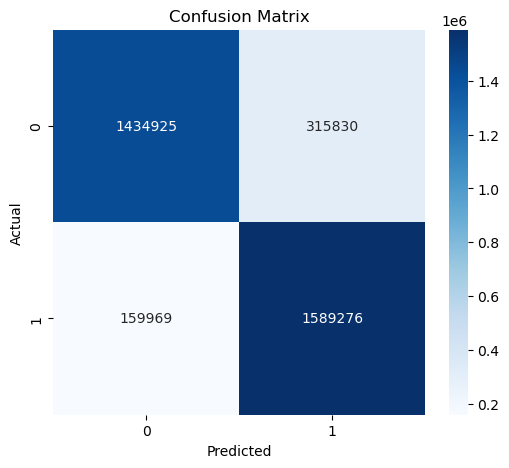

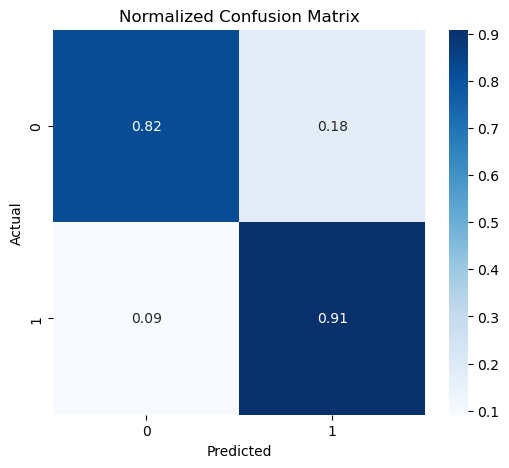

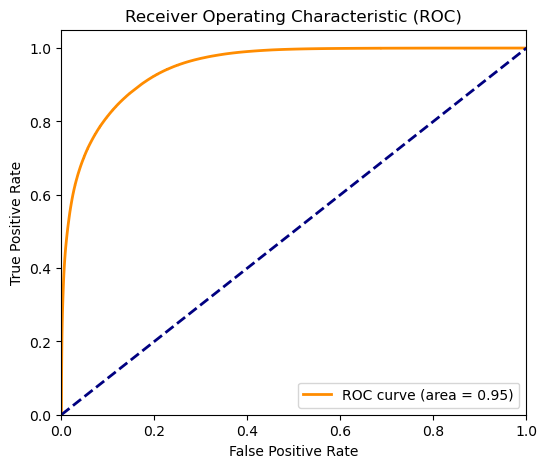

ROC AUC Score: 0.9467
CPU times: user 1h 19min 56s, sys: 12min 15s, total: 1h 32min 12s
Wall time: 1h 31min 43s


In [2]:
%%time
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Splitting
# ---------------------------
# Load CSV files using cuDF (GPU-accelerated)
train_df = cudf.read_csv("all_train.csv")
test_df = cudf.read_csv("all_test.csv")

# Convert to pandas DataFrames for easier integration with PyTorch
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()

# Define features and target
feature_columns = train_pd.columns.drop("# label")
target_column = "# label"

# Split train_pd into training and validation sets (e.g., 80-20 split)
train_data, val_data = train_test_split(train_pd, test_size=0.2, random_state=42, stratify=train_pd[target_column])

# Print dataset shapes
print("Dataset Shapes:")
print("  Training set shape:", train_data.shape)
print("  Validation set shape:", val_data.shape)
print("  Test set shape:", test_pd.shape)

# ---------------------------
# 2. Create PyTorch Dataset
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_columns, target_column):
        self.X = dataframe[feature_columns].values.astype('float32')
        self.y = dataframe[target_column].values.astype('int64')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset objects for train, validation, and test sets
train_dataset = CustomDataset(train_data, feature_columns, target_column)
val_dataset   = CustomDataset(val_data, feature_columns, target_column)
test_dataset  = CustomDataset(test_pd, feature_columns, target_column)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# 3. Define the Neural Network
# ---------------------------
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim  = len(feature_columns)
hidden_dim = 64      # adjust as needed
output_dim = 2       # binary classification: two classes

model = NeuralNet(input_dim, hidden_dim, output_dim)

# ---------------------------
# 4. Setup GPU & cuDNN
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True  # can improve performance for fixed-size inputs
    print("\nGPU found! Using GPU:", torch.cuda.get_device_name(0))
else:
    print("\nNo GPU found. Using CPU.")

# ---------------------------
# 5. Define Loss, Optimizer and Learning Rate
# ---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# 5.5 Print Model Architecture and Dimensions
# ---------------------------
print("\nModel Architecture:")
print(model)
print("\nModel Parameter Dimensions:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
print("\n")

# ---------------------------
# 6. Training Loop with Epoch-level Logging
# ---------------------------
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    epoch_start_time = time.time()
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
    
    avg_val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    epoch_time = time.time() - epoch_start_time
    
    # Get current learning rate (assuming one parameter group)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary in a single line
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.2f}% | "
          f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}% | LR: {current_lr:.6f} | "
          f"Epoch Time: {epoch_time:.2f} sec")

# ---------------------------
# 7. Evaluate on Test Set and Compute Metrics
# ---------------------------
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []  # probability for positive class

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()
        test_total += X_batch.size(0)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(y_batch.cpu().numpy())
        # Calculate probabilities using softmax; take probability of class "1"
        probs = nn.functional.softmax(outputs, dim=1)
        all_test_probs.extend(probs[:, 1].cpu().numpy())

avg_test_loss = test_loss / test_total
test_accuracy = 100 * test_correct / test_total

print("\nTest Set Evaluation:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.2f}%\n")

# ---------------------------
# 8. Classification Report
# ---------------------------
print("Classification Report:")
print(classification_report(all_test_labels, all_test_preds, digits=4))

# ---------------------------
# 9. Confusion Matrix (Raw and Normalized)
# ---------------------------
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------
# 10. ROC Curve and ROC AUC Score
# ---------------------------
# Compute ROC AUC Score
roc_auc = roc_auc_score(all_test_labels, all_test_probs)
fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")
